## Extract FLASH Data in yt
David Schneidinger

9/26/24

Use yt's covering_grid class to extract data from FLASH.

In [1]:
# https://yt-project.org/

import yt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# plot_path = "~/shared/data/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"
# plot_path = "~/shared/data/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"
plot_path = "~/shared/data/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0028"
input_filename = "magshockz-v3.0.2d"
output_dir = Path(f"/home/dschneidinger/MagShockZ/input_files/{input_filename}")
if not output_dir.exists():
    output_dir.mkdir()

In [3]:
# Certain fields are not directly output by FLASH, but can be derived from the fields that are output.
# For example, the number density of electrons and each ion species
# Everything, with the exception of the thermal velocities (which are in osiris units), are in cgs

import sys
sys.path.append("../src")
from load_derived_FLASH_fields import derive_fields
ds = derive_fields(plot_path,rqm=100,ion_2='Si')

yt : [INFO     ] 2024-12-03 11:25:32,042 Particle file found: MagShockZ_hdf5_chk_0028
yt : [INFO     ] 2024-12-03 11:25:32,143 Parameters: current_time              = 1.0532564210672338e-08
yt : [INFO     ] 2024-12-03 11:25:32,144 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2024-12-03 11:25:32,144 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2024-12-03 11:25:32,145 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2024-12-03 11:25:32,145 Parameters: cosmological_simulation   = 0


In [6]:
# this is from the yt documentation

level = 0
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)
all_data

YTCoveringGrid (MagShockZ_hdf5_chk_0028): , level=0, left_edge=[-0.8   -0.075 -0.8  ] cm, ActiveDimensions=[384 496 384]

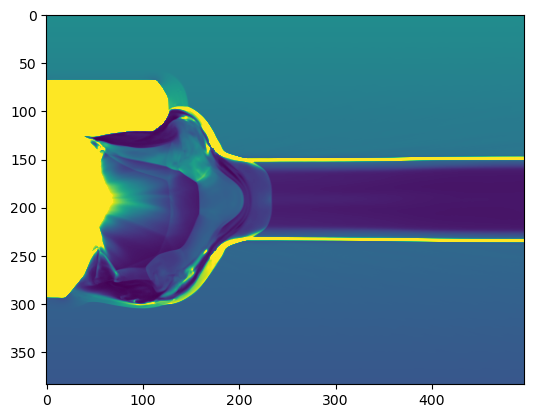

In [15]:
plt.imshow(all_data['flash',"dens"][:,:,(all_data['flash',"dens"].shape[0])//2],vmax = 1e-4)

In [18]:
# All of these numbers come from the INITIAL conditions of FLASH, not the actual values at the given time


ne_cgs = 5e18 # [cm^-3]
e = 4.80320425e-10 # [statC] = [cm^3/2⋅g^1/2⋅s^−1]
m_e = 9.1093837139e-28 # [g]
c = 2.99792458e10 # [cm/s]
kb = 8.617333262e-5 # [eV/K]
proton_mass = 1.6726219e-24 # [g]
# B = 150000 # [Gauss]
B = 75000 # [Gauss]
T_e = 40 # [eV]
Al_charge_state = 6
erg_per_eV = 1.60218e-12 # [erg/eV]


rqm = 100 # [m_e]

# from Wikipedia
aluminum_molecular_weight = 26.981 
# magnesium_molecular_weight = 24.305
silicon_molecular_weight = 28.0855


omega_pe = np.sqrt(4*np.pi*ne_cgs*e**2/m_e)
omega_pi = np.sqrt(4*np.pi*ne_cgs*Al_charge_state*e**2/(proton_mass*aluminum_molecular_weight)) # extra charge state factor got absorbed into ne
print(f"ion inertial length {c/omega_pi} cm")
omega_pi_osiris = np.sqrt(4*np.pi*ne_cgs*e**2/(rqm*m_e))

rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
alfven_speed = B/np.sqrt(4*np.pi*rho_0) # check this factor of 4pi
print(f"FLASH alfven speed: {np.format_float_scientific(alfven_speed,2)} cm/s")

print(f"alfven speed in ion inertial length/ion plasma-time {alfven_speed/(c/omega_pi)*omega_pi**-1}")
print(f"in osiris this would be {(alfven_speed/(c/omega_pi)*omega_pi**-1)*(omega_pe/omega_pi_osiris)**2}")

alfven_speed_osiris = (B/np.sqrt(4*np.pi*ne_cgs*rqm*m_e))/c
print(f"OSIRIS alfven speed: {alfven_speed_osiris,2} c")
print(f"OSIRIS alfven speed: {np.format_float_scientific(c*alfven_speed_osiris,2)} cm/s")


debye_length = np.sqrt(T_e*erg_per_eV/(4*np.pi*ne_cgs*e**2))
print(f"debye length {debye_length} cm")
print(f"debye length in electron inertial lengths {debye_length/(c/omega_pe)}")

print(f"debye length in the dense part of the piston however")
debye_length = np.sqrt(2e7*kb*erg_per_eV/(4*np.pi*4e20*e**2))
print(f"would require a resolution of {(c/omega_pe)/debye_length} cells per debye length")

ion inertial length 0.021594939868701025 cm
FLASH alfven speed: 3.45e+06 cm/s
alfven speed in ion inertial length/ion plasma-time 0.00011507959931913132
in osiris this would be 0.011507959931913132
OSIRIS alfven speed: (0.0010456976407270222, 2) c
OSIRIS alfven speed: 3.13e+07 cm/s
debye length 2.102638729930706e-06 cm
debye length in electron inertial lengths 0.008847497481780927
debye length in the dense part of the piston however
would require a resolution of 154.01148172067667 cells per debye length


In [19]:
def save_slice(normalizations:dict, target_index:int=0): # 84 was the number for old sims, 250 is for new
    '''
    args: normalizations: dict, target_index: int
    normalizations: dict
        key: str, field name
        value: float, normalization factor. Note: function automatically divides by this factor
    target_index: int
        index of the edge of the target

    Note: Density data will be output as a numpy array because OSIRIS uses its own interpolator for density data
    '''
    import multiprocessing as mp
    import pickle
    from scipy.interpolate import RegularGridInterpolator
    
    interp_dir = output_dir / "interp"
    if not (interp_dir).exists():
        (interp_dir).mkdir()
        
    z_middle_index=dims[2]//2

    chunk_size = 100  # Adjust this based on your memory constraints


    for (field, normalization) in normalizations.items():
        field_data = np.zeros(all_data['flash', field][:, target_index:, z_middle_index].shape)
        for i in range(0, all_data['flash', field].shape[0], chunk_size):
            end = min(i + chunk_size, all_data['flash', field].shape[0])
            field_data_chunk = np.array(all_data['flash', field][i:end, target_index:, z_middle_index]) / normalization
            field_data[i:end, :] = field_data_chunk

        if field.endswith('dens'):
            lower_bound = 0.01
            field_data[field_data < lower_bound] = 0
            np.save(f"{interp_dir}/{field}.npy", field_data)
        else:
            x = all_data['flash', 'x'][:, 0, 0] * omega_pe / c
            y = all_data['flash', 'y'][0, target_index:, 0] * omega_pe / c
            interp1 = RegularGridInterpolator((y, x), field_data.T, method='linear', bounds_error=True, fill_value=0)
            with open(f"{interp_dir}/{field}.pkl", "wb") as f:
                pickle.dump(interp1, f)

In [20]:
# This can take a while and always seems to crash the kernel if you try to do more than 1 or 2. Uncomment as needed


# This is normalizing with electron frequency
normalizations = {
    'aldens':ne_cgs, # check this normalization
    'edens':ne_cgs,
    'sidens':ne_cgs,
    'magx':(omega_pe*m_e*c)/e,
    'magy':(omega_pe*m_e*c)/e,
    'magz':(omega_pe*m_e*c)/e,
    'Ex':(omega_pe*m_e*c)/e*alfven_speed/alfven_speed_osiris,
    'Ey':(omega_pe*m_e*c)/e*alfven_speed/alfven_speed_osiris, 
    'Ez':(omega_pe*m_e*c)/e*alfven_speed/alfven_speed_osiris,
}
save_slice(normalizations)
# print(normalizations.items())
# This is normalizing with ion frequency
normalizations = {
    # 'aldens':ne_cgs, # check this normalization
    # 'edens':ne_cgs,
    # 'mgdens':ne_cgs,
    # 'magx':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c)/e,
    # 'magy':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c)/e,
    # 'magz':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c)/e,
    # 'Ex':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c**2)/e,
    # 'Ey':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c**2)/e, 
    # 'Ez':((omega_pi*omega_pe/omega_pi_osiris)*m_e*c**2)/e,
}
# save_slice(normalizations)



In [22]:
normalizations = {
    'velx':alfven_speed/alfven_speed_osiris,
    'vely':alfven_speed/alfven_speed_osiris,
    'velz':alfven_speed/alfven_speed_osiris,
    'vthele':c, # already normalized
    'vthal':c, # already normalized
    'vthsi':c, # already normalized
}
save_slice(normalizations)

In [23]:
target_index = 0

x_ion = all_data['flash','x'][:,0,0]*omega_pi/c
print(f"Bounds of simulation in ion inertial length: x {round(x_ion.value[0],1)},{round(x_ion.value[-1],1)} c/omega_pi")
y_ion = all_data['flash','y'][0,target_index:,0]*omega_pi/c
print(f"Bounds of simulation in ion inertial length: y {round(y_ion.value[0],1)},{round(y_ion.value[-1],1)} c/omega_pi")

print()

x = all_data['flash','x'][:,0,0]*omega_pe/c
print(f"Bounds of simulation in osiris units: x {round(x.value[0],0)},{round(x.value[-1],0)} c/omega_pe")
y = all_data['flash','y'][0,target_index:,0]*omega_pe/c
print(f"Bounds of simulation in osiris units: y {round(y.value[0],0)},{round(y.value[-1],0)} c/omega_pe")

print()

x_ion_osiris = all_data['flash','x'][:,0,0]*(omega_pi*omega_pe/omega_pi_osiris)/c
print(f"If we seek to conserve ion inertial length: x {round(x_ion_osiris.value[0],1)},{round(x_ion_osiris.value[-1],1)} c/omega_pe")
y_ion_osiris = all_data['flash','y'][0,target_index:,0]*(omega_pi*omega_pe/omega_pi_osiris)/c
print(f"If we seek to conserve ion inertial length: y {round(y_ion_osiris.value[0],1)},{round(y_ion_osiris.value[-1],1)} c/omega_pe")



Bounds of simulation in ion inertial length: x -36.9,36.9 c/omega_pi
Bounds of simulation in ion inertial length: y -3.4,92.5 c/omega_pi

Bounds of simulation in osiris units: x -3357.0,3357.0 c/omega_pe
Bounds of simulation in osiris units: y -307.0,8407.0 c/omega_pe

If we seek to conserve ion inertial length: x -369.5,369.5 c/omega_pe
If we seek to conserve ion inertial length: y -33.8,925.2 c/omega_pe


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_34522/2708726377.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("x [c/$\omega_{pe}$]")
/tmp/ipykernel_34522/2708726377.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("y [c/$\omega_{pe}$]")


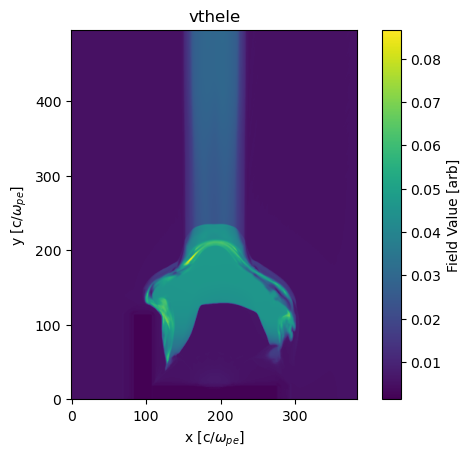

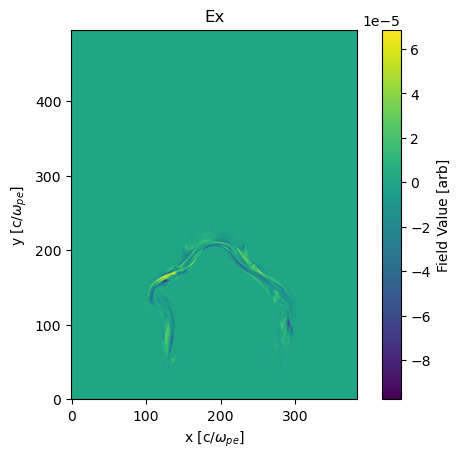

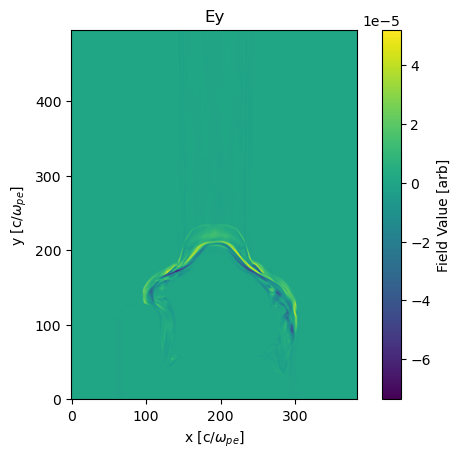

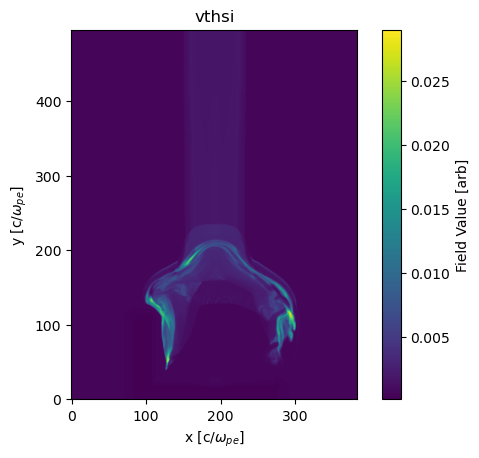

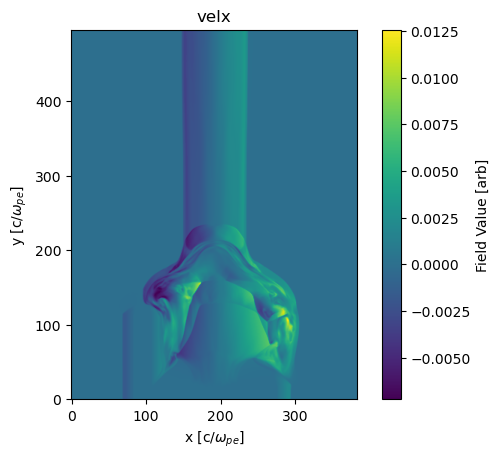

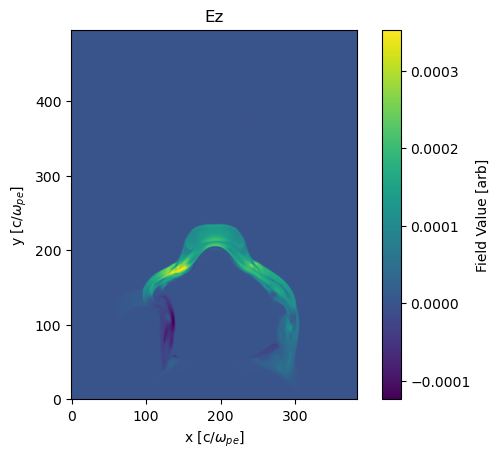

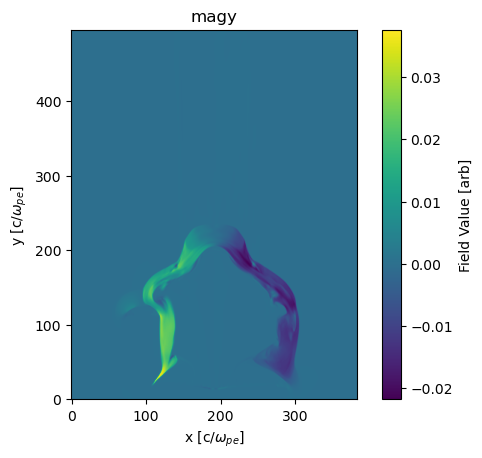

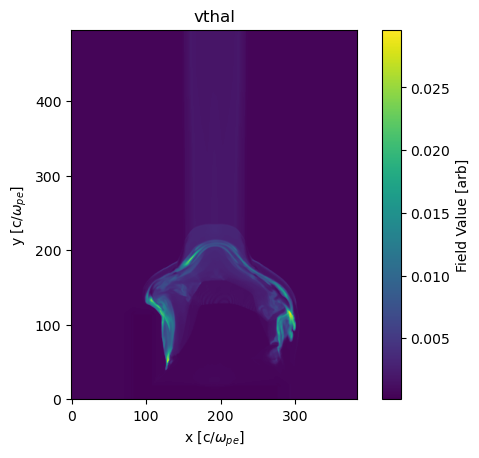

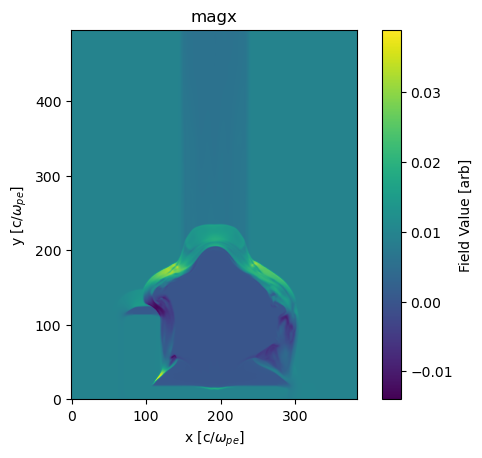

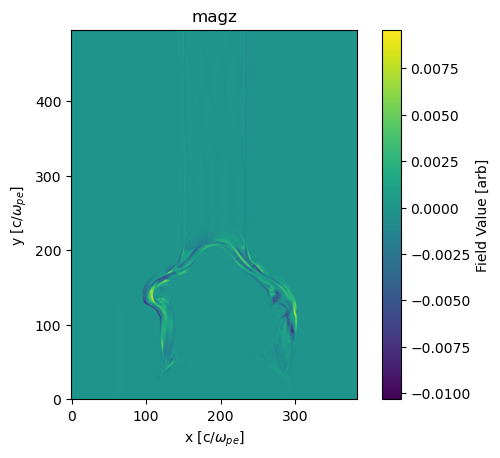

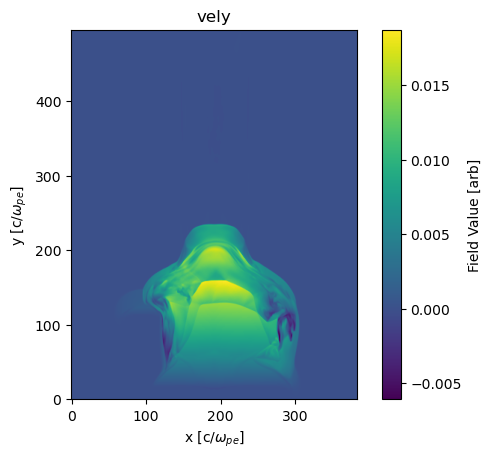

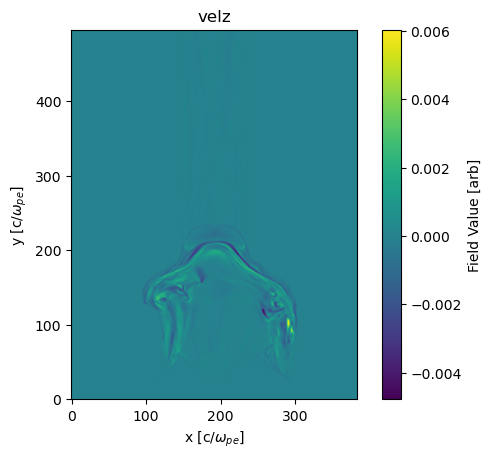

In [24]:
from pathlib import Path
import pickle

X1, X2 = np.meshgrid( x, y, indexing='xy' )

# Change this if looking at another simulation
interp_dir = output_dir / "interp"
interp_files = interp_dir.glob("*.pkl")

for f in interp_files:
    name = f.stem
    with open(f, "rb") as f:
        loaded_interpolator = pickle.load(f)
    synthetic = loaded_interpolator((X2,X1))


    plt.imshow(synthetic, origin='lower')
    cbar = plt.colorbar()
    cbar.set_label('Field Value [arb]')
    plt.title(name)
    plt.xlabel("x [c/$\omega_{pe}$]")
    plt.ylabel("y [c/$\omega_{pe}$]")
    plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_34522/3969225606.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("x [c/$\omega_{pe}$]")
/tmp/ipykernel_34522/3969225606.py:12: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("y [c/$\omega_{pe}$]")


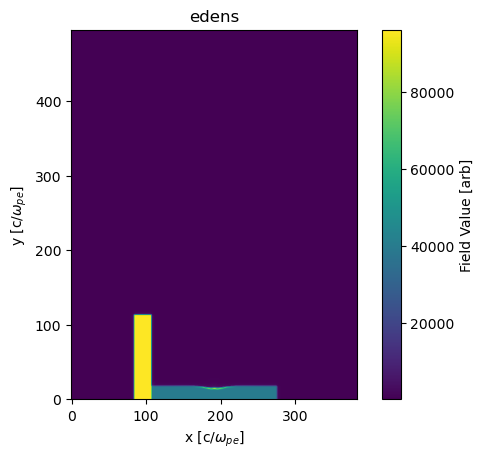

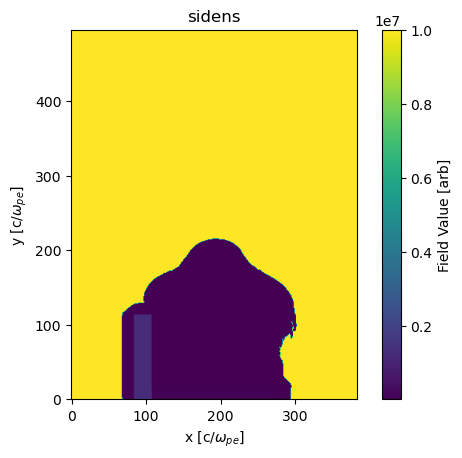

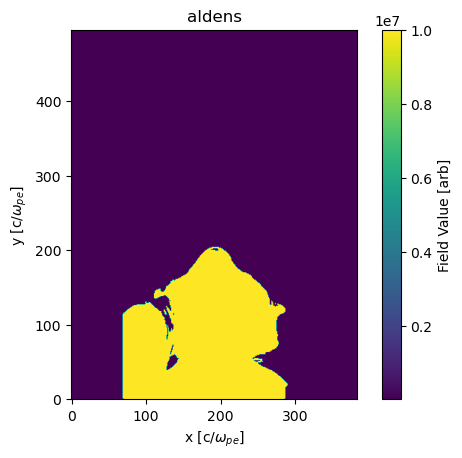

In [26]:

interp_files = interp_dir.glob("*.npy")

for f in interp_files:
    name = f.stem
    data = np.load(f).T
    data[data ==0]= 10000000
    plt.imshow(data, origin='lower')
    cbar = plt.colorbar()
    cbar.set_label('Field Value [arb]')
    plt.title(name)
    plt.xlabel("x [c/$\omega_{pe}$]")
    plt.ylabel("y [c/$\omega_{pe}$]")
    plt.show()

In [65]:
from pathlib import Path
import pickle
angle = np.pi/2
r = np.linspace(0,5000,1000)
start_point = [0,1900]

X1, X2 = np.meshgrid( x, y, indexing='xy' )

# Change this if looking at another simulation
interp_dir = output_dir / "interp"
interp_files = interp_dir.glob("*.pkl")

for f in interp_files:
    name = f.stem
    with open(f, "rb") as f:
        loaded_interpolator = pickle.load(f)
    synthetic = loaded_interpolator((r*np.sin(angle)+start_point[1],r*np.cos(angle)+start_point[0]))


    plt.plot(r, synthetic)
    plt.title(name)
    plt.xlabel("r [c/$\omega_{pe}$]")
    plt.ylabel("val [c/$\omega_{pe}$]")
    plt.show()

# interp_files = interp_dir.glob("*.npy")

# for f in interp_files:
#     name = f.stem
#     plt.imshow(np.load(f).T, origin='lower')
#     cbar = plt.colorbar()
#     cbar.set_label('Field Value [arb]')
#     plt.title(name)
#     plt.xlabel("x [c/$\omega_{pe}$]")
#     plt.ylabel("y [c/$\omega_{pe}$]")
#     plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_24117/3804358552.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("r [c/$\omega_{pe}$]")
/tmp/ipykernel_24117/3804358552.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("val [c/$\omega_{pe}$]")
/tmp/ipykernel_24117/3804358552.py:22: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("r [c/$\omega_{pe}$]")
/tmp/ipykernel_24117/3804358552.py:23: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("val [c/$\omega_{pe}$]")


ValueError: One of the requested xi is out of bounds in dimension 0